# Surface Flux Taylor Series
This notebook uses output from Isca to perform taylor series decompostion on both latent and sensible heat fluxes.

In [56]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile, sphum_sat, clausius_clapeyron_factor
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, get_heat_capacity
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, annual_mean, fourier
from isca_tools.utils.constants import c_p, R, R_v, kappa, L_v, c_p_water, rho_water
from isca_tools.thesis.hottest_date import get_var_extrema_date
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize
import copy
from scipy.interpolate import CubicSpline
from scipy import integrate

## Load in data

In [57]:
# Load dataset
var_keep = ['flux_t', 'flux_lhe', 'temp', 'ps', 'sphum', 't_surf', 'w_atm', 'drag_q', 'drag_t', 'rho', 'q_atm', 'q_surf', 't_atm', 'p_atm', 
            'lwdn_sfc', 'lwup_sfc', 'swdn_sfc']
exp_names = ['aquaplanet/no_wishe/k=1', 'aquaplanet/no_wishe/normal_wind']
# exp_names = ['aquaplanet/no_wishe/k=1', 'aquaplanet/no_wishe/k=1_normal_drag']
n_exp = len(exp_names)
use_time_start = 360*2
# only load in atmos level closest to surface, for times after spin up
ds_base = [isca_tools.load_dataset(exp_names[i]).sel(pfull=np.inf, method='nearest')[var_keep] for i in range(n_exp)] 
for i in range(n_exp):
    ds_base[i] = ds_base[i].sel(time=slice(use_time_start, np.inf))
# namelist = isca_tools.load_namelist(exp_names[0])  # Need this for albedo_value
w_atm_const = [isca_tools.load_namelist(exp_names[i])['surface_flux_nml']['w_atm_const'] for i in range(n_exp)]
mixed_layer_depth = [isca_tools.load_namelist(exp_names[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]


KeyboardInterrupt



In [402]:
# Consider a single latitude
loc = {'lat': 60}
ds_sl = [ds_base[i].sel(lat=loc['lat'], method='nearest').load() for i in range(n_exp)]
ds_sl_av = [annual_mean(ds_base[i].sel(lat=loc['lat'], method='nearest')).mean(dim='lon').load() for i in range(n_exp)]
n_year_days = 360
time_array = np.arange(n_year_days)

## Reconstructing zonal-annual mean Surface Fluxes
Here I compare the fluxes output by Isca, `flux_lhe` and `flux_t`, with the reconstructed fluxes found using the individual variables output from Isca.

If I do all the averaging after I have multiplied the variables together (top figure), then the two fluxes match almost exactly.
If I average the variables first and then compute the fluxes from them, then the two match less well (bottom figure).

If you say do the zonal mean of the variables, compute the fluxes, and then do the time annual average on these fluxes, it is the same as if you averaged all the variables first.

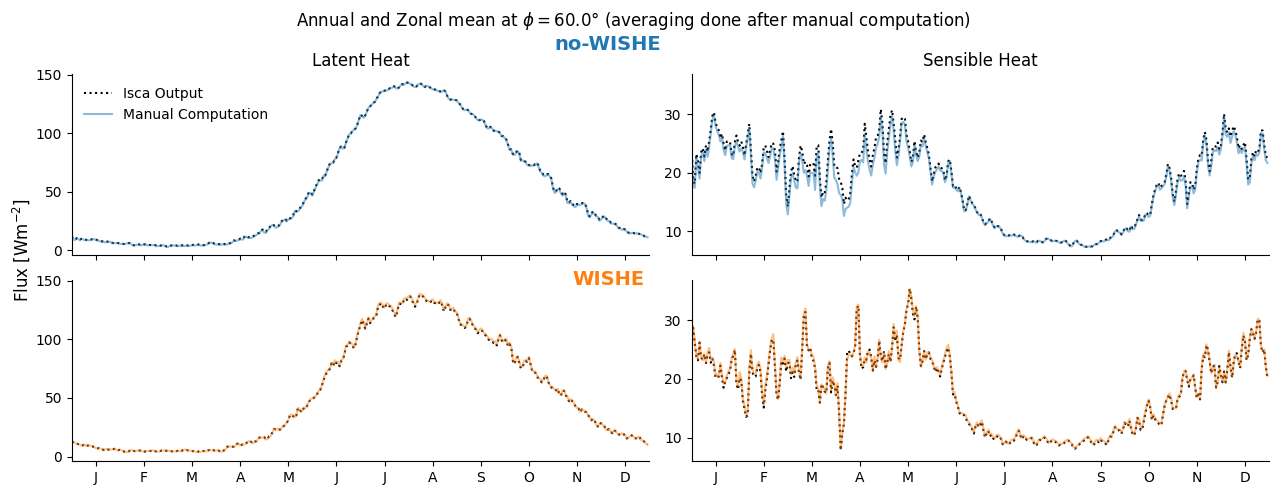

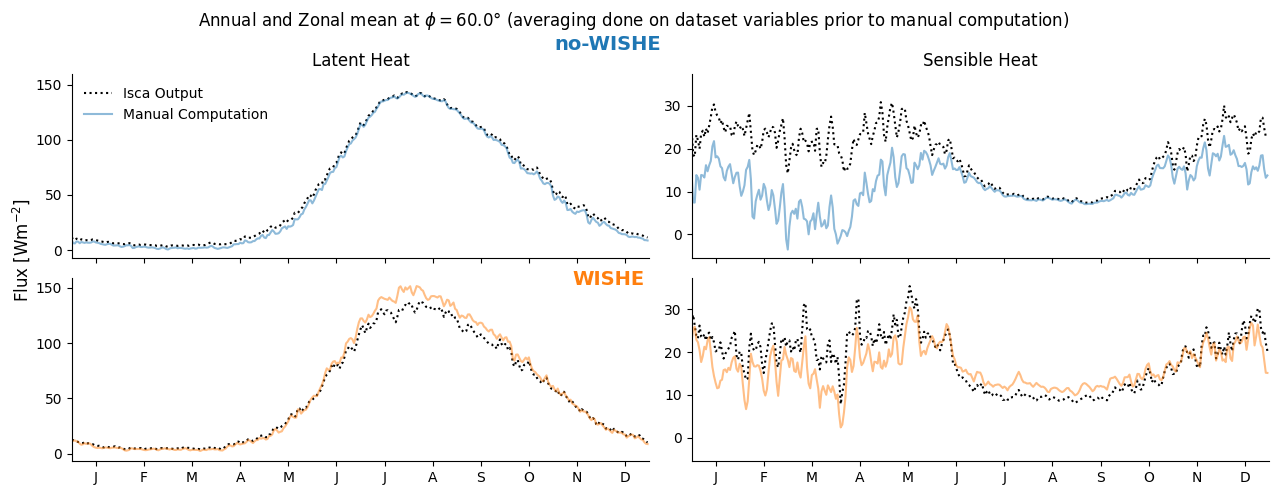

In [403]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
exp_labels = ['no-WISHE', '']
if 'normal_drag' in exp_names[1]:
    exp_labels[1] = 'no-WISHE (normal drag)'
    exp_labels[0] = 'no-WISHE (constant wind drag)'
elif 'normal_wind' in exp_names[1]:
    exp_labels[1] = 'WISHE'
else:
    raise ValueError('unsure what experiment second index refers to')
# for ds_all in [ds_sl, ds_sl_av, [annual_mean(ds_sl[j]) for j in range(n_exp)], [ds_sl[j].mean(dim='lon') for j in range(n_exp)]]:
for ds_all in [ds_sl, ds_sl_av]:
    w_atm_use = [w_atm_const[i] if w_atm_const[i]>0 else ds_all[i].w_atm for i in range(n_exp)]
    flux_lh_manual = [ds_use.drag_q * w_atm_use[i] * ds_use.rho * (ds_use.q_surf - ds_use.q_atm) * L_v for i, ds_use in enumerate(ds_all)]
    flux_sh_manual = [ds_use.drag_t * w_atm_use[i] * ds_use.rho * (ds_use.t_surf - ds_use.t_atm * (ds_use.ps/ds_use.p_atm)**kappa) * c_p for 
                      i, ds_use in enumerate(ds_all)]
       
    fig, ax = plt.subplots(n_exp,2, figsize=(13, 5), sharex=True, sharey='col')
    take_annual_mean = ds_all[0].time[-1]>n_year_days
    take_zonal_mean = 'lon' in ds_all[0]
    if take_zonal_mean and take_annual_mean:
        av_func = lambda x: annual_mean(x).mean(dim='lon')
        av_title = 'averaging done after manual computation'
    elif take_annual_mean:
        av_func = lambda x: annual_mean(x)
        av_title = 'zonal averaging done on dataset variables prior to manual computation' 
    elif take_zonal_mean:
        av_func = lambda x: x.mean(dim='lon')
        av_title = 'temporal averaging done on dataset variables prior to manual computation' 
    else:
        av_func = lambda x: x
        av_title = 'averaging done on dataset variables prior to manual computation' 
    for i, ds_use in enumerate(ds_all):
        ax[i, 0].spines[['top', 'right']].set_visible(False)
        ax[i, 1].spines[['top', 'right']].set_visible(False)
        ax[i, 0].plot(time_array, av_func(ds_use.flux_lhe), color='k', linestyle=':', label='Isca Output')
        ax[i, 0].plot(time_array, av_func(flux_lh_manual[i]), alpha=0.5, color=default_colors[i], label='Manual Computation')
        
        ax[i, 1].plot(time_array, av_func(ds_use.flux_t), color='k', linestyle=':')
        ax[i, 1].plot(time_array, av_func(flux_sh_manual[i]), alpha=0.5, color=default_colors[i])
        # ax[i, 1].plot(time_array, flux_sh_manual2[i], alpha=0.5)
        
        # ax[1].plot(ds.time, ds.flux_t, color='k', linestyle=':')
        # ax[1].plot(ds.time, flux_sh_manual, alpha=0.5)
        # ax[1].plot(ds.time, flux_sh_manual2, alpha=0.5)
    ax[0, 0].legend(frameon=False)
    ax[0, 0].set_title('Latent Heat')
    ax[0, 1].set_title('Sensible Heat')
    ax[0, 0].set_xticks(*month_ticks)
    ax[0, 0].set_xlim(0, n_year_days)
    plt.figtext(0.48,0.93, exp_labels[0], ha="center", va="top", fontsize=14, color=default_colors[0], fontweight='bold')
    plt.figtext(0.48,0.46, exp_labels[1], ha="center", va="top", fontsize=14, color=default_colors[1], fontweight='bold')
    fig.supylabel('Flux [Wm$^{-2}$]')
    fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$ ({av_title})")
    # ax[0].set_ylabel('Flux [W/m$^2$]')
    # fig.supxlabel('Time [days]')
    # fig.suptitle(f"Lat = {loc_use['lat']}$\degree$; Lon = {loc_use['lon']}$\degree$")
    plt.tight_layout()

## Temperature Dependence of Fluxes
Look whether removing WISHE affects the temperature dependence of the fluxes.

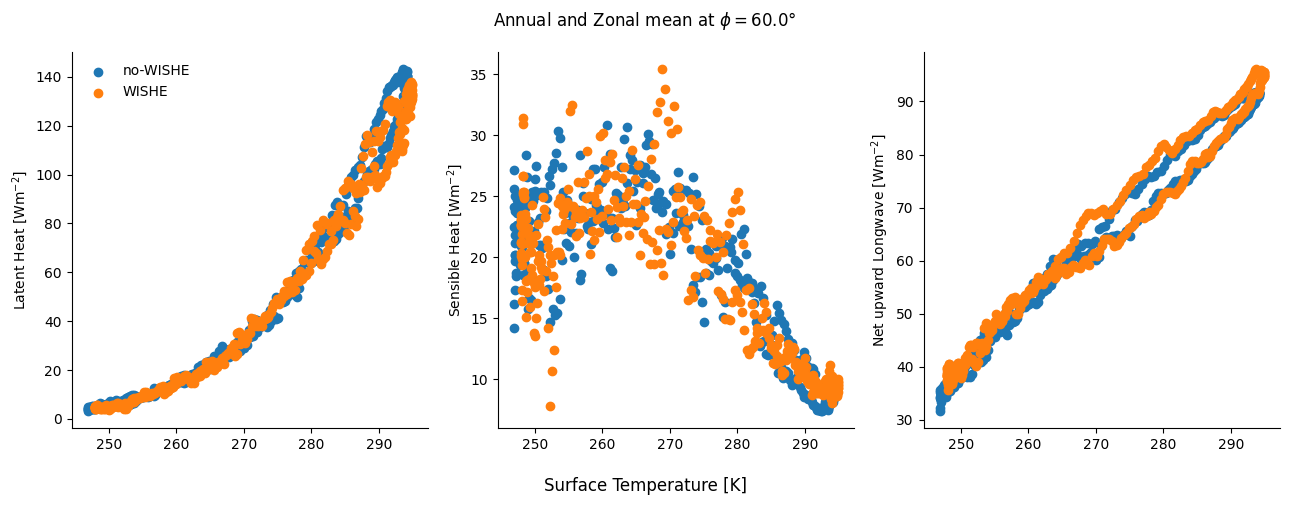

In [404]:
fig, ax = plt.subplots(1,3, figsize=(13, 5), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)
for i in range(n_exp):
    ax[0].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].flux_lhe, color=default_colors[i], label=exp_labels[i])
    ax[1].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].flux_t, color=default_colors[i])
    ax[2].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].lwup_sfc - ds_sl_av[i].lwdn_sfc, color=default_colors[i])
ax[0].legend(frameon=False)
ax[0].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[1].set_ylabel('Sensible Heat [Wm$^{-2}$]')
ax[2].set_ylabel('Net upward Longwave [Wm$^{-2}$]')
fig.supxlabel('Surface Temperature [K]')
fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$')
plt.tight_layout();

## Compare flux time series with and without WISHE

This shows the effect of wind speed on seasonal cycle of surface fluxes

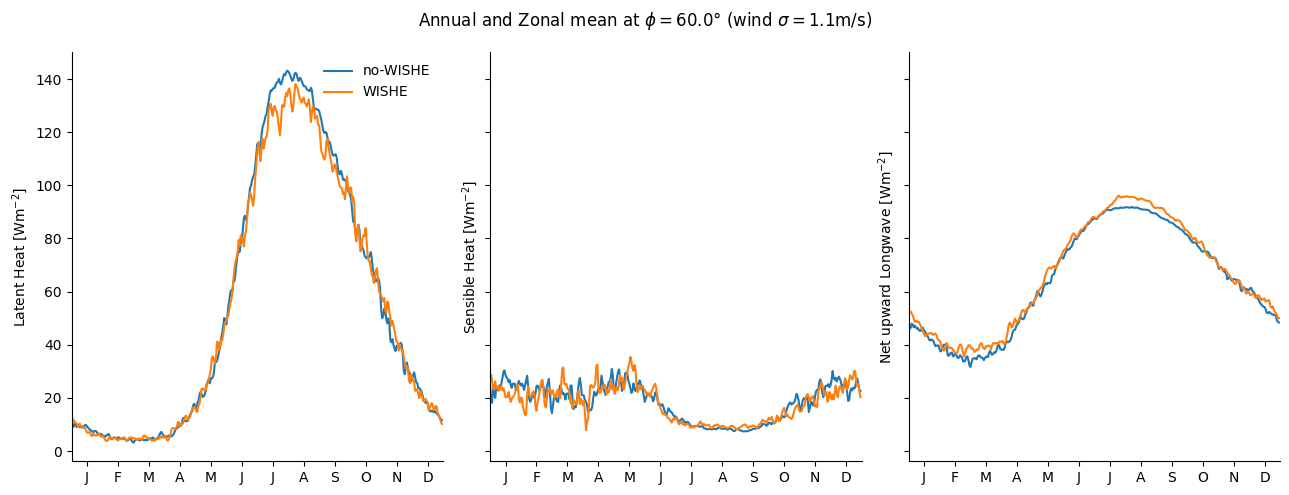

In [405]:
fig, ax = plt.subplots(1,3, figsize=(13, 5), sharex=True, sharey=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)
for i in range(n_exp):
    ax[0].plot(time_array, ds_sl_av[i].flux_lhe, color=default_colors[i], label=exp_labels[i])
    ax[1].plot(time_array, ds_sl_av[i].flux_t, color=default_colors[i])
    ax[2].plot(time_array, ds_sl_av[i].lwup_sfc - ds_sl_av[i].lwdn_sfc, color=default_colors[i])
ax[0].legend(frameon=False)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(0, n_year_days)
ax[0].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[1].set_ylabel('Sensible Heat [Wm$^{-2}$]')
ax[2].set_ylabel('Net upward Longwave [Wm$^{-2}$]')
fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$ (wind $\sigma = {round(float(ds_sl_av[1].w_atm.std()), 1)}$m/s)')
plt.tight_layout()

## Latent Heat Taylor Series
The equation for latent heat is $LH = L_v C_q\rho_a |v|(q_s - q_a)$, where $\rho_a = \frac{p_a}{RT_{a_v}}$ and $T_{a_v} = (1+\frac{1-\epsilon}{\epsilon}q_{a})T_{a}$ is the virtual temperature. $a$ indicates the lowest level of the atmosphere and $s$ indicates the surface. It is shown by the blue line below.

Ignoring the virtual temperature correction, this becomes: $LH \approx L_v C_q\frac{p_{a}}{RT_{a}} |v|(q_{s} - q_{a})$, and is shown by the orange line below.

If we substitute $q_{s} = q^*(T_{s}, p_s)$, we get the green line.

If do a taylor series expansion of $q^*(T_a, p_a)$ about $T_s$ and $p_s$, we get $q_a = r_aq^*(T_a, p_a) \approx r_aq^*(T_s, p_s)(1+\alpha_sT_{a-s})$ where $T_{a-s} = T_a - T_s$ and $r_a$ is the relative humidity. 
From this, we then have $LH \approx L_v C_q\frac{p_{a}}{RT_{a}} |v|q^*_s(1 - r_a(1+\alpha_sT_{a-s}))$ which is shown by the red line below.

Clearly from the plot below, these approximations are all very good. It gives us an expression for latent heat which depends on 7 variables: $p_s$, $p_{a}$, $r_a$, $T_s$, $T_{a-s}$, $|v|$ and $C_q$.
$$LH \approx L_v C_q\frac{p_{a}}{R(T_{s}+T_{a-s})} |v|q^*(T_s, p_s)\big(1 - r_a(1+\alpha(T_s, p_s)T_{a-s})\big)$$

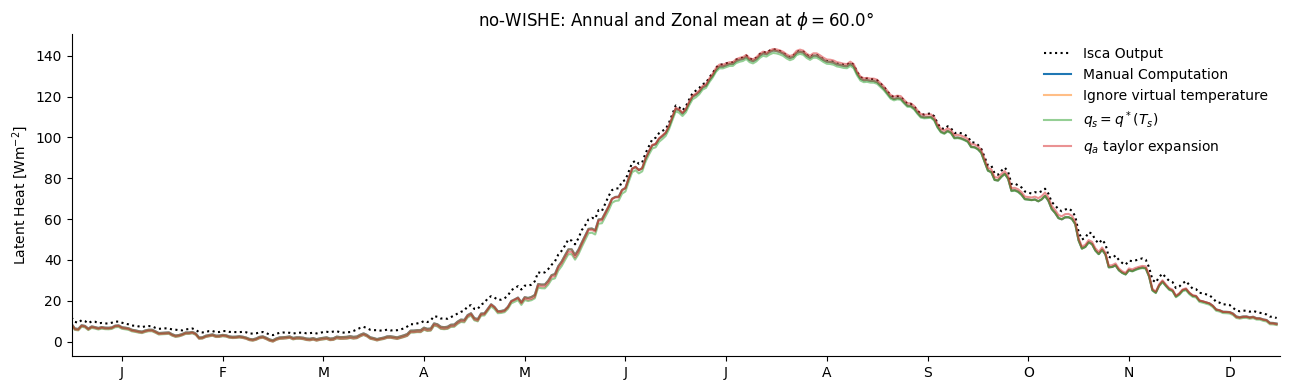

In [406]:
exp_ind_use = 0
ds_use = ds_sl_av[exp_ind_use]
w_atm_use_taylor = w_atm_use[exp_ind_use]
flux_lh_manual2 = ds_use.drag_q * w_atm_use_taylor * (ds_use.p_atm/(R*ds_use.t_atm)) * (ds_use.q_surf - ds_use.q_atm) * L_v
flux_lh_manual3 = ds_use.drag_q * w_atm_use_taylor * (ds_use.p_atm/(R*ds_use.t_atm)) * (sphum_sat(ds_use.t_surf, ds_use.ps) - ds_use.q_atm) * L_v
r_a = ds_use.q_atm / sphum_sat(ds_use.t_atm, ds_use.p_atm)
alpha_s_full = clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps)
t_a_s = ds_use.t_atm - ds_use.t_surf
flux_lh_manual4 = ds_use.drag_q * w_atm_use_taylor * (ds_use.p_atm/(R*ds_use.t_atm)) * sphum_sat(ds_use.t_surf, ds_use.ps) * \
                  (1 - r_a * (1+alpha_s_full*t_a_s)) * L_v

fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(time_array, ds_use.flux_lhe, color='k', linestyle=':', label='Isca Output')
ax.plot(time_array, flux_lh_manual[exp_ind_use], color=default_colors[0], label='Manual Computation')
ax.plot(time_array, flux_lh_manual2, color=default_colors[1], alpha=0.5, label='Ignore virtual temperature')
ax.plot(time_array, flux_lh_manual3, color=default_colors[2], alpha=0.5, label='$q_{s} = q^*(T_s)$')
ax.plot(time_array, flux_lh_manual4, color=default_colors[3], alpha=0.5, label='$q_{a}$ taylor expansion')
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('Latent Heat [Wm$^{-2}$]')
ax.legend(frameon=False)
ax.set_title(f"{exp_labels[exp_ind_use]}: Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$")
plt.tight_layout()

### Final Approximation
The plots below show that $q^*(T_s, p_s) \approx q^*(T_s, \overline{p_s})$ and $\alpha(T_s, p_s) \approx \alpha(T_s, \overline{p_s})$, where $\overline{p_s}$ is the average of surface pressure over all time. This helps simplify further by eliminating the $p_s$ dependence so there are now only 6 variables:
$$LH \approx L_v C_q\frac{p_{a}}{R(T_{s}+T_{a-s})} |v|q^*(T_s)\big(1 - r_a(1+\alpha(T_s)T_{a-s})\big)$$
This final approximation is shown below in orange.

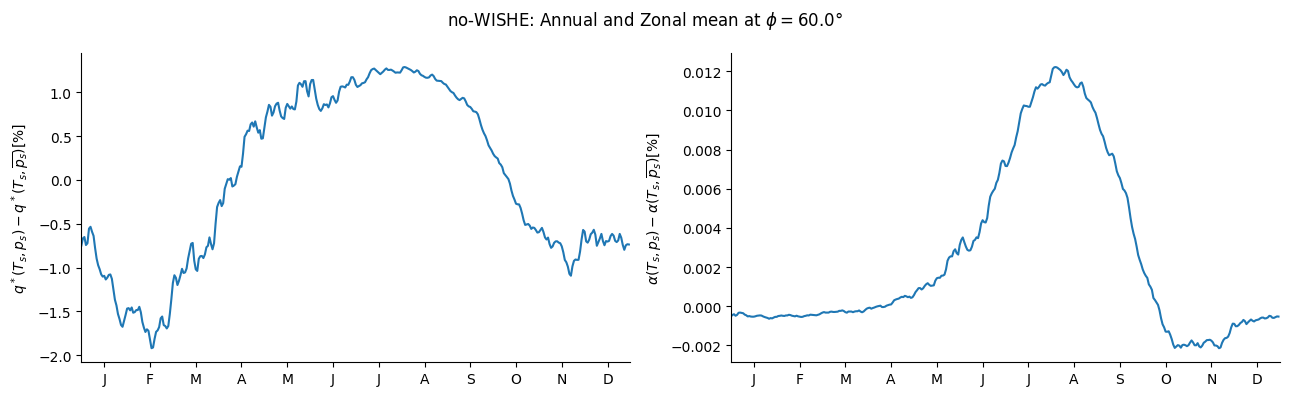

In [407]:
fig, ax = plt.subplots(1,2, figsize=(13, 4), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[0].plot(time_array, 100*(sphum_sat(ds_use.t_surf, ds_use.ps)-sphum_sat(ds_use.t_surf, ds_use.ps.mean()))/sphum_sat(ds_use.t_surf, ds_use.ps))
ax[1].plot(time_array, 100*(clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps)-clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps.mean()))
           /clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps))
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(0, n_year_days)
ax[0].set_ylabel('$q^*(T_s, p_s) - q^*(T_s, \overline{p_s}) [\%]$')
ax[1].set_ylabel('$\\alpha(T_s, p_s) - \\alpha(T_s, \overline{p_s}) [\%]$')
fig.suptitle(f"{exp_labels[exp_ind_use]}: Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$")
plt.tight_layout()

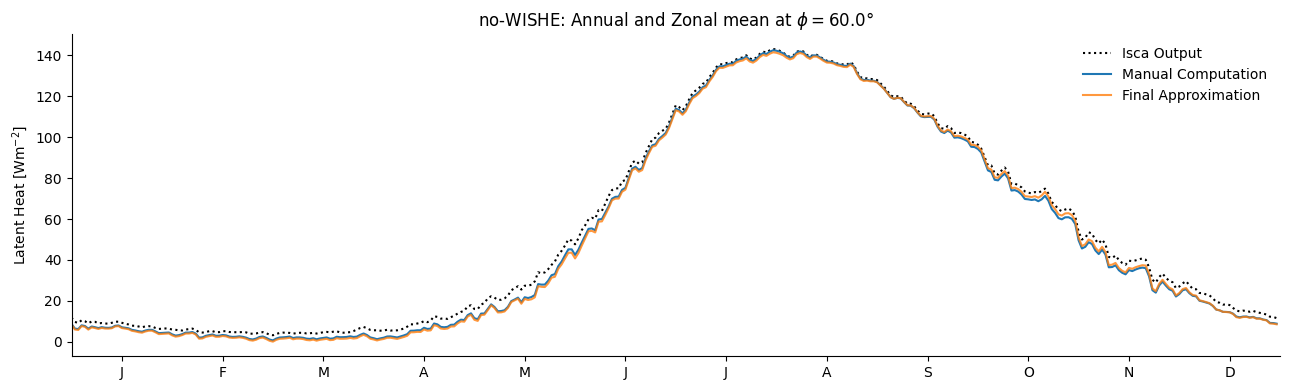

In [408]:
def lh_approx(ds_use, ps, w_a):
    # ds_use - dataset at a single latitude and longitude, with n_year_days values for each variable
    # ps - [float] surface pressure in Pa
    # w_a - [float or DataArray of size n_year_days] lowest level atmospheric wind speed to use. Either constant or one value for each time.
    alpha_s = clausius_clapeyron_factor(ds_use.t_surf, ps)
    r_a = ds_use.q_atm / sphum_sat(ds_use.t_atm, ds_use.p_atm)
    t_a_s = ds_use.t_atm - ds_use.t_surf
    return L_v * ds_use.drag_q * w_a * (ds_use.p_atm/(R*ds_use.t_atm)) * sphum_sat(ds_use.t_surf, ps) * (1 - r_a * (1+alpha_s*t_a_s))

def lh_approx_mean(ds_mean, ps, w_a_mean, r_a_mean, t_a_s_mean):
    alpha_s_mean = clausius_clapeyron_factor(ds_mean.t_surf, ps)
    return L_v * ds_mean.drag_q * w_a_mean * (ds_mean.p_atm/(R*(ds_mean.t_surf+t_a_s_mean))) * sphum_sat(ds_mean.t_surf, ps) * (
            1 - r_a_mean * (1+alpha_s_mean*t_a_s_mean))

fig_lh_approx, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(time_array, ds_use.flux_lhe, color='k', linestyle=':', label='Isca Output')
ax.plot(time_array, flux_lh_manual[exp_ind_use], color=default_colors[0], label='Manual Computation')
ax.plot(time_array, lh_approx(ds_use, ds_use.ps.mean(), w_atm_use_taylor), color=default_colors[1], alpha=0.8, label='Final Approximation')
ax.legend(frameon=False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('Latent Heat [Wm$^{-2}$]')
ax.set_title(f"{exp_labels[exp_ind_use]}: Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$")
plt.tight_layout()

### Latent Heat Decomposition
Diagnose the variables which give the major contributions to the variation in latent heat, through a taylor series analysis.

In [409]:
def lh_taylor_decomp(ds_use, ps, w_a, mean_axis=None, include_three_var_terms=False):
    if isinstance(w_a, float):
        w_a_mean = w_a
    else:
        w_a_mean = w_a.mean(axis=mean_axis)
    
    var = {'t_s': ds_use.t_surf, 't_a_s': ds_use.t_atm - ds_use.t_surf, 'r_a': ds_use.q_atm / sphum_sat(ds_use.t_atm, ds_use.p_atm), 
           'p_a': ds_use.p_atm, 'drag_q': ds_use.drag_q, 'w_a': w_a}
    var_mean = {key: var[key] if isinstance(var[key], float) else float(var[key].mean(axis=mean_axis)) for key in var}
    var_delta = {key: var[key] - var_mean[key] for key in var}
    alpha_s_mean = clausius_clapeyron_factor(var_mean['t_s'], ps)
    lh_mean = float(lh_approx_mean(ds_use.mean(), ps, w_a_mean, var_mean['r_a'], var_mean['t_a_s']))
    
    lh_taylor_coefs = {}
    lh_taylor_terms = {}
    q_s_mean = sphum_sat(var_mean['t_s'], ps)
    pre_factor_mean = L_v * var_mean['drag_q'] * var_mean['w_a'] * var_mean['p_a']/(R*(var_mean['t_s']+var_mean['t_a_s']))
    
    # Full form
    # lh_taylor_coefs['t_s'] = lh_mean * (alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s'])
    #                                     ) + 2*alpha_s_mean * var_mean['r_a'] * var_mean['t_a_s'] / var_mean['t_s'] * pre_factor_mean * q_s_mean
    # Simple form
    lh_taylor_coefs['t_s'] = lh_mean * (alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))
    # From simpler t_s form
    lh_taylor_coefs['t_s_squared'] = lh_mean * ((alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))**2 + 
                                                (1/(var_mean['t_s']+var_mean['t_a_s'])**2 - 2*alpha_s_mean/var_mean['t_s']))
    
    lh_taylor_coefs['r_a'] = -pre_factor_mean * q_s_mean * (1+alpha_s_mean*var_mean['t_a_s'])
    lh_taylor_coefs['t_a_s'] = -lh_mean/(var_mean['t_s']+var_mean['t_a_s'])-var_mean['r_a']*alpha_s_mean*pre_factor_mean*q_s_mean
    for key in ['drag_q', 'p_a', 'w_a']:
        lh_taylor_coefs[key] = lh_mean/var_mean[key]
        
    lh_taylor_coefs['t_s_r_a'] = lh_taylor_coefs['t_s']/lh_mean * lh_taylor_coefs['r_a']
    lh_taylor_coefs['t_s_squared_r_a'] = lh_taylor_coefs['t_s_squared']/lh_mean * lh_taylor_coefs['r_a']
    lh_taylor_coefs['t_s_t_a_s'] = lh_mean/(var_mean['t_s']+var_mean['t_a_s'])**2 + (
            alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s'])) * lh_taylor_coefs['t_a_s']
    lh_taylor_coefs['t_s_squared_t_a_s'] = lh_mean * (2/(var_mean['t_s']+var_mean['t_a_s'])**2 * (alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s'])) - 
                                                      2/(var_mean['t_s']+var_mean['t_a_s'])**3) + \
                                           lh_taylor_coefs['t_a_s']/lh_mean * lh_taylor_coefs['t_s_squared']
    lh_taylor_coefs['r_a_t_a_s'] = -lh_taylor_coefs['r_a']/(var_mean['t_s']+var_mean['t_a_s']) - alpha_s_mean * pre_factor_mean * q_s_mean
    
    lh_taylor_coefs['t_s_drag_q'] = lh_taylor_coefs['t_s'] / var_mean['drag_q']
    lh_taylor_coefs['t_a_s_drag_q'] = lh_taylor_coefs['t_a_s'] / var_mean['drag_q']
    lh_taylor_coefs['r_a_drag_q'] = lh_taylor_coefs['r_a'] / var_mean['drag_q']
    lh_taylor_coefs['t_s_squared_drag_q'] = lh_taylor_coefs['t_s_squared'] / var_mean['drag_q']
    
    lh_taylor_coefs['t_s_w_a'] = lh_taylor_coefs['t_s']/var_mean['w_a']
    lh_taylor_coefs['t_s_squared_w_a'] = lh_taylor_coefs['t_s_squared']/var_mean['w_a']
    lh_taylor_coefs['r_a_w_a'] = lh_taylor_coefs['r_a']/var_mean['w_a']
    lh_taylor_coefs['t_a_s_w_a'] = lh_taylor_coefs['t_a_s']/var_mean['w_a']
    
    lh_taylor_coefs['t_s_cubed'] = lh_mean * (6*alpha_s_mean/var_mean['t_s']**2 - 2/(var_mean['t_s']+var_mean['t_a_s'])**3 + 
                                              2*(alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))*
                                              (1/(var_mean['t_s']+var_mean['t_a_s'])**2-2*alpha_s_mean/var_mean['t_s'])) + \
                                   lh_taylor_coefs['t_s_squared']/lh_mean * lh_taylor_coefs['t_s']
    lh_taylor_coefs['t_s_cubed_r_a'] = lh_taylor_coefs['t_s_cubed']/lh_mean * lh_taylor_coefs['r_a']
    lh_taylor_coefs['t_s_cubed_t_a_s'] = lh_taylor_coefs['t_a_s'] * (6*alpha_s_mean/var_mean['t_s']**2 - 2/(var_mean['t_s']+var_mean['t_a_s'])**3 + 
                                              2*(alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))*
                                              (1/(var_mean['t_s']+var_mean['t_a_s'])**2-2*alpha_s_mean/var_mean['t_s'])) + lh_mean * (
        6/(var_mean['t_s']+var_mean['t_a_s'])**4 + 2/(var_mean['t_s']+var_mean['t_a_s'])**2 * (1/(var_mean['t_s']+var_mean['t_a_s'])**2 -
                                                                                               2*alpha_s_mean/var_mean['t_s']) 
        - 4/(var_mean['t_s']+var_mean['t_a_s'])**3 * (alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))
    ) + 1/lh_mean * (-1/lh_mean * lh_taylor_coefs['t_s_squared'] * lh_taylor_coefs['t_s'] * lh_taylor_coefs['t_a_s'] + 
                    lh_taylor_coefs['t_s_squared_t_a_s']*lh_taylor_coefs['t_s'] + lh_taylor_coefs['t_s_squared'] * lh_taylor_coefs['t_s_t_a_s'])
    lh_taylor_coefs['t_s_cubed_w_a'] = lh_taylor_coefs['t_s_cubed'] / var_mean['w_a']
    lh_taylor_coefs['t_s_cubed_drag_q'] = lh_taylor_coefs['t_s_cubed'] / var_mean['drag_q']
    
    lh_taylor_coefs['drag_q_w_a'] = lh_taylor_coefs['drag_q'] / var_mean['w_a']
    
    if include_three_var_terms:
        lh_taylor_coefs['t_s_r_a_drag_q'] = lh_taylor_coefs['t_s_r_a'] / var_mean['drag_q']
        lh_taylor_coefs['t_s_t_a_s_drag_q'] = lh_taylor_coefs['t_s_t_a_s'] / var_mean['drag_q']
        lh_taylor_coefs['t_s_squared_r_a_drag_q'] = lh_taylor_coefs['t_s_squared_r_a'] / var_mean['drag_q']
        lh_taylor_coefs['t_s_squared_t_a_s_drag_q'] = lh_taylor_coefs['t_s_squared_t_a_s'] / var_mean['drag_q']
        lh_taylor_coefs['t_s_cubed_r_a_drag_q'] = lh_taylor_coefs['t_s_cubed_r_a'] / var_mean['drag_q']
    
    
    var_delta['t_s_squared'] = 0.5 * var_delta['t_s']**2
    var_delta['t_s_r_a'] = var_delta['t_s'] * var_delta['r_a']
    var_delta['t_s_squared_r_a'] = 0.5 * var_delta['t_s']**2 * var_delta['r_a']
    var_delta['t_s_t_a_s'] = var_delta['t_s'] * var_delta['t_a_s']
    var_delta['t_s_squared_t_a_s'] = 0.5 * var_delta['t_s']**2 * var_delta['t_a_s']
    var_delta['r_a_t_a_s'] = var_delta['r_a'] * var_delta['t_a_s']
    var_delta['t_s_drag_q'] = var_delta['t_s'] * var_delta['drag_q']
    var_delta['t_a_s_drag_q'] = var_delta['t_a_s'] * var_delta['drag_q']
    var_delta['r_a_drag_q'] = var_delta['r_a'] * var_delta['drag_q']
    var_delta['t_s_squared_drag_q'] = 0.5 * var_delta['t_s']**2 * var_delta['drag_q']
    var_delta['t_s_w_a'] = var_delta['t_s'] * var_delta['w_a']
    var_delta['t_s_squared_w_a'] = 0.5 * var_delta['t_s']**2 * var_delta['w_a']
    var_delta['r_a_w_a'] = var_delta['r_a'] * var_delta['w_a']
    var_delta['t_a_s_w_a'] = var_delta['t_a_s'] * var_delta['w_a']
    var_delta['t_s_cubed'] = 1/6 * var_delta['t_s']**3
    var_delta['t_s_cubed_r_a'] = 1/6 * var_delta['t_s']**3 * var_delta['r_a']
    var_delta['t_s_cubed_t_a_s'] = 1/6 * var_delta['t_s']**3 * var_delta['t_a_s']
    var_delta['t_s_cubed_w_a'] = 1/6 * var_delta['t_s']**3 * var_delta['w_a']
    var_delta['t_s_cubed_drag_q'] = 1/6 * var_delta['t_s']**3 * var_delta['drag_q']
    var_delta['drag_q_w_a'] = var_delta['drag_q'] * var_delta['w_a']
    var_delta['t_s_r_a_drag_q'] = var_delta['t_s'] * var_delta['r_a'] * var_delta['drag_q']
    var_delta['t_s_t_a_s_drag_q'] = var_delta['t_s'] * var_delta['t_a_s'] * var_delta['drag_q']
    var_delta['t_s_squared_r_a_drag_q'] = 0.5 * var_delta['t_s']**2 * var_delta['r_a'] * var_delta['drag_q']
    var_delta['t_s_squared_t_a_s_drag_q'] = 0.5 * var_delta['t_s']**2 * var_delta['t_a_s'] * var_delta['drag_q']
    var_delta['t_s_cubed_r_a_drag_q'] = 1/6 * var_delta['t_s']**3 * var_delta['r_a'] * var_delta['drag_q']
    for key in lh_taylor_coefs:
        lh_taylor_terms[key] = var_delta[key] * lh_taylor_coefs[key]
    return lh_mean, lh_taylor_terms
    
include_three_var = False
lh_sv_mean, lh_sv_taylor_terms = lh_taylor_decomp(ds_use, ds_use.ps.mean(), w_atm_use_taylor, include_three_var_terms=include_three_var) 

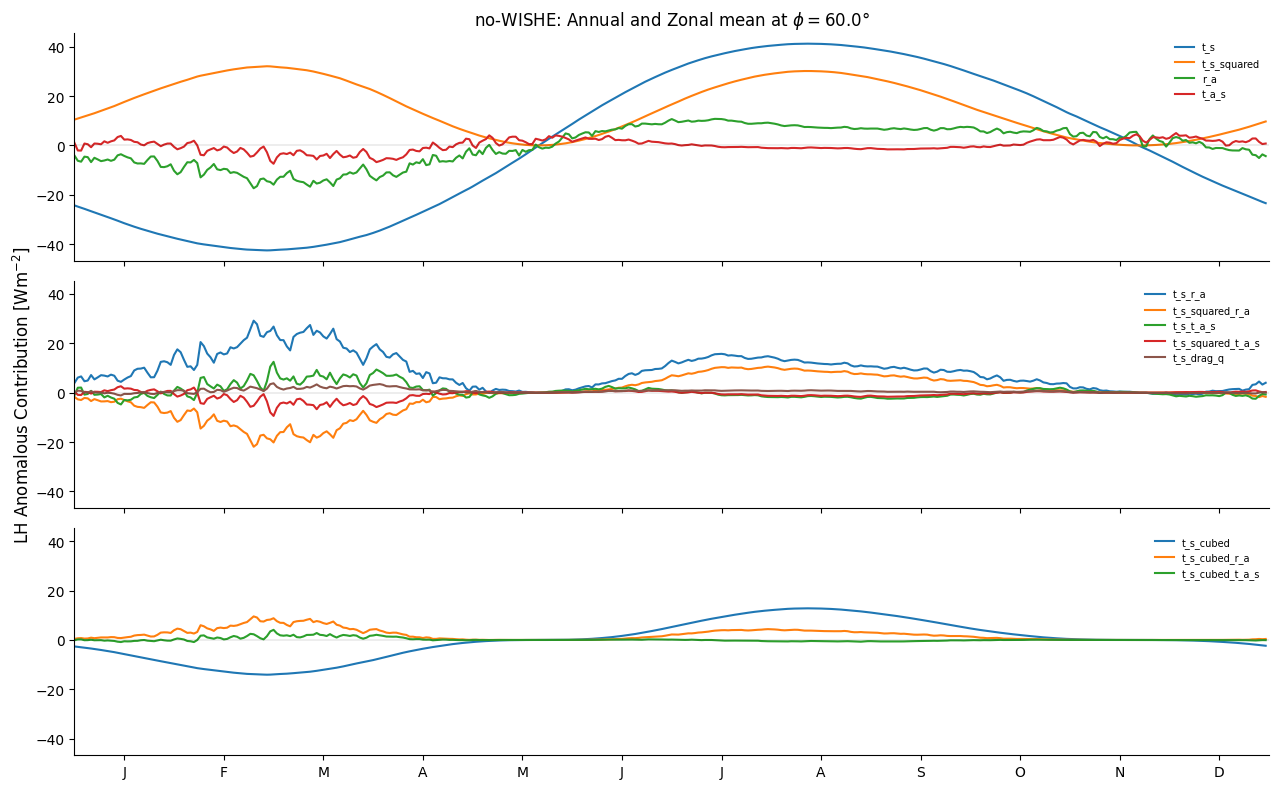

In [410]:
fig, ax = plt.subplots(4+int(include_three_var) if exp_labels[exp_ind_use] == 'WISHE' else 3+int(include_three_var), 1, figsize=(13, 8), 
                       sharex=True, sharey=True)
first_plot_names = ['drag_q', 'p_a', 'r_a', 't_a_s', 't_s', 't_s_squared', 'w_a']
three_var_names = ['t_s_r_a_drag_q', 't_s_t_a_s_drag_q', 't_s_squared_r_a_drag_q', 't_s_squared_t_a_s_drag_q', 't_s_cubed_r_a_drag_q']
min_plot_val = 3                # only show terms where max contribution is more than 5 W/m^2
color_ind = [-1] * len(ax)      # so color of given term is always the same (as sometimes term will be ignored)
for key in lh_sv_taylor_terms:
    if 'w_a' in key:
        ax_ind = -1
    elif key in first_plot_names:
        ax_ind = 0
    elif key in three_var_names:
        ax_ind = 3
    elif 'cubed' in key:
        ax_ind = 2
    else:
        ax_ind = 1
    if 'w_a' in key and exp_labels[exp_ind_use] != 'WISHE':
        continue
    color_ind[ax_ind] += 1
    if np.abs(lh_sv_taylor_terms[key]).max() > min_plot_val:
        ax[ax_ind].plot(time_array, lh_sv_taylor_terms[key], label=key, color=default_colors[color_ind[ax_ind]])
for i in range(len(ax)):
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].legend(fontsize=7, loc='upper right', edgecolor='white', framealpha=1)
    ax[i].hlines(0, 0, 360, color='k', lw=0.1)
ax[-1].set_xticks(*month_ticks)
ax[-1].set_xlim(0, n_year_days)
fig.supylabel('LH Anomalous Contribution [Wm$^{-2}$]')
ax[0].set_title(f"{exp_labels[exp_ind_use]}: Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$")
plt.tight_layout()

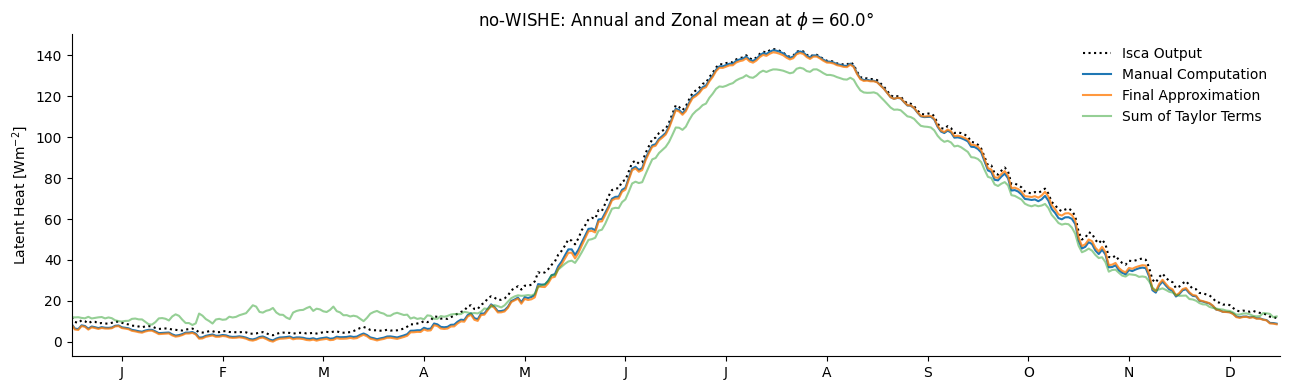

In [430]:
fig = copy.deepcopy(fig_lh_approx)
ax = fig.gca()
ax.plot(lh_sv_mean+sum(lh_sv_taylor_terms.values()), label='Sum of Taylor Terms', color=default_colors[2], alpha=0.5)
# lh_sv_taylor_terms['r_a'] = 0
# ax.plot(lh_sv_mean+sum(lh_sv_taylor_terms.values()), label='Sum of Taylor Terms with no RH', color=default_colors[2], alpha=0.5, linestyle=':')
ax.legend(frameon=False)
fig
# plt.plot(flux_lh_manual4)
# plt.plot(a[0]+sum(a[1].values()))
# plt.plot(2*(ds_use.t_surf - ds_use.t_surf.mean()))

### Correlation of relative humidity with surface temperature

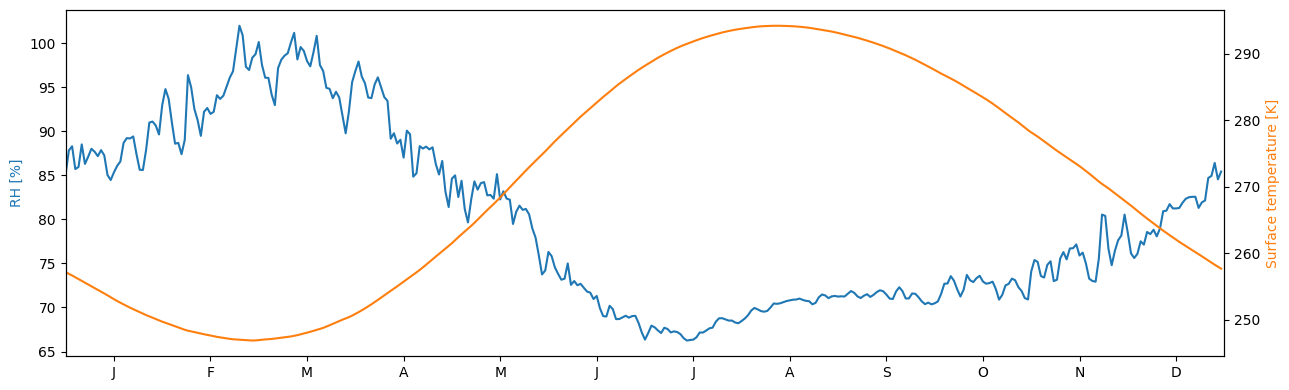

In [412]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(time_array, 100*ds_use.q_atm/sphum_sat(ds_use.t_atm, ds_use.p_atm))
ax2 = ax.twinx()
ax2.plot(time_array, ds_use.t_surf, color=default_colors[1])
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('RH [%]', color=default_colors[0])
ax2.set_ylabel('Surface temperature [K]', color=default_colors[1])
plt.tight_layout()

### Correlation of relative humidity with specific humidity
Relative humidity seems to get very high, even exceeding 100%, when specific humidity is very small in winter.

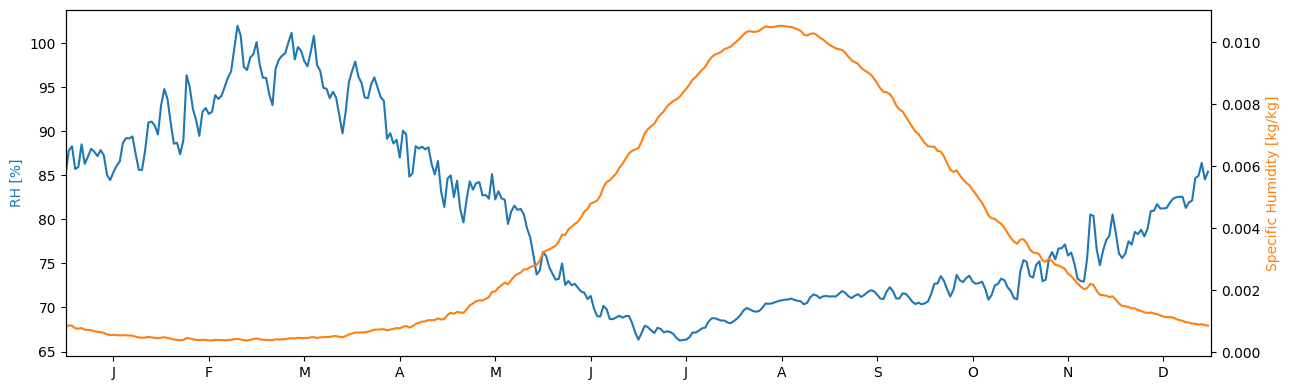

In [413]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(time_array, 100*ds_use.q_atm/sphum_sat(ds_use.t_atm, ds_use.p_atm))
ax2 = ax.twinx()
ax2.plot(time_array, ds_use.q_atm, color=default_colors[1])
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('RH [%]', color=default_colors[0])
ax2.set_ylabel('Specific Humidity [kg/kg]', color=default_colors[1])
plt.tight_layout()

### Correlation of relative humidity with $T_{a-s}$


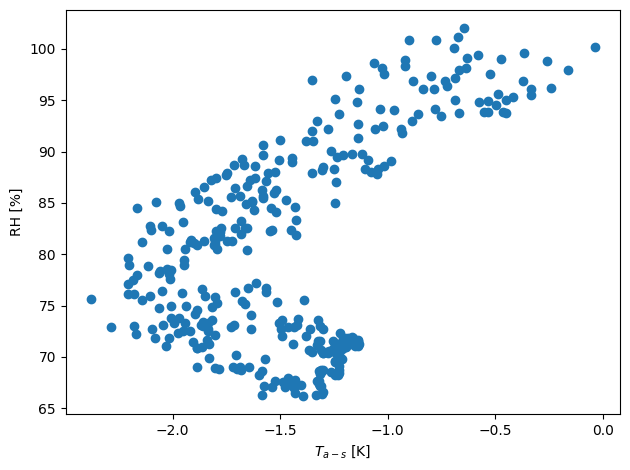

In [414]:
# Plot to see whether relative humidity and T_{a-s} are correlated
plt.scatter(ds_use.t_atm-ds_use.t_surf, 100*ds_use.q_atm/sphum_sat(ds_use.t_atm, ds_use.p_atm))
plt.ylabel('RH [%]')
plt.xlabel('$T_{a-s}$ [K]')
plt.tight_layout()

## Effect of wind in WISHE
The first plot below, shows that when the wind is low, the sum of all the taylor series terms differs from the full approximation. This indicates that some taylor series terms (probably some three variable terms) are missing from the expansion.

The second plot is looking at how the drag coefficient influences surface temperature.

In [415]:
# Plot that shows taylor expansion deviates from full approximation when wind is low.
# Only important for WISHE experiments.
if exp_labels[exp_ind_use] == 'WISHE':
    fig, ax = plt.subplots(1,1, figsize=(13, 4))
    ax.plot(time_array, lh_sv_mean+sum(lh_sv_taylor_terms.values())-lh_approx(ds_use, ds_use.ps.mean(), w_atm_use_taylor))
    ax2 = ax.twinx()
    ax2.plot(time_array, w_atm_use_taylor, color=default_colors[1])
    ax.set_xticks(*month_ticks)
    ax.set_xlim(0, n_year_days)
    ax.set_ylabel('Sum of Taylor Terms - Final Approximation [Wm$^{-2}$]', color=default_colors[0])
    ax2.set_ylabel('$w_a$ [m/s]', color=default_colors[1])
    ax.set_title(f"{exp_labels[exp_ind_use]}: Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$")
    plt.tight_layout()

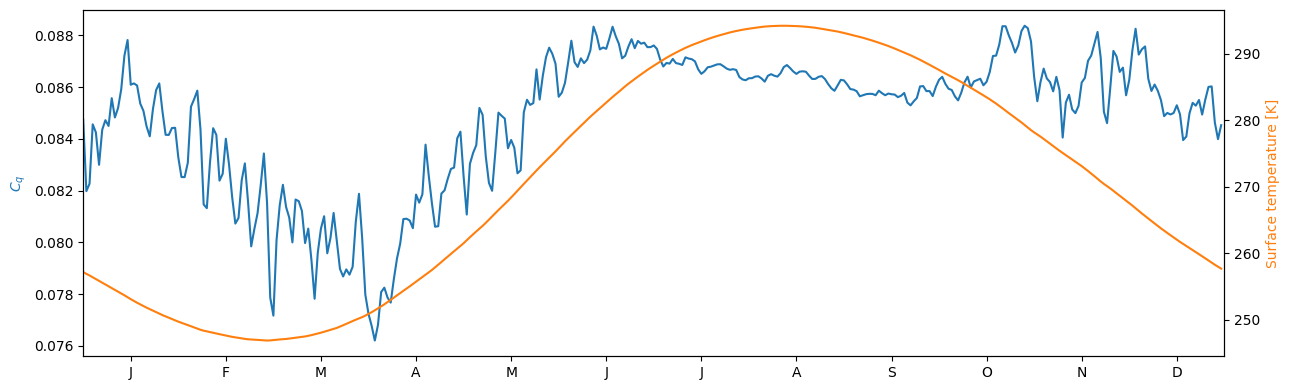

In [416]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(time_array, 100*ds_use.drag_q)
ax2 = ax.twinx()
ax2.plot(time_array, ds_use.t_surf, color=default_colors[1])
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('$C_q$', color=default_colors[0])
ax2.set_ylabel('Surface temperature [K]', color=default_colors[1])
plt.tight_layout()

## Empirical Fitting
To get solution for hottest day of the year, we need to represent $\Gamma^{\uparrow} = LW^{\uparrow} - LW^{\downarrow} + SH^{\uparrow} + LH^{\uparrow}$ as a function of temperature.

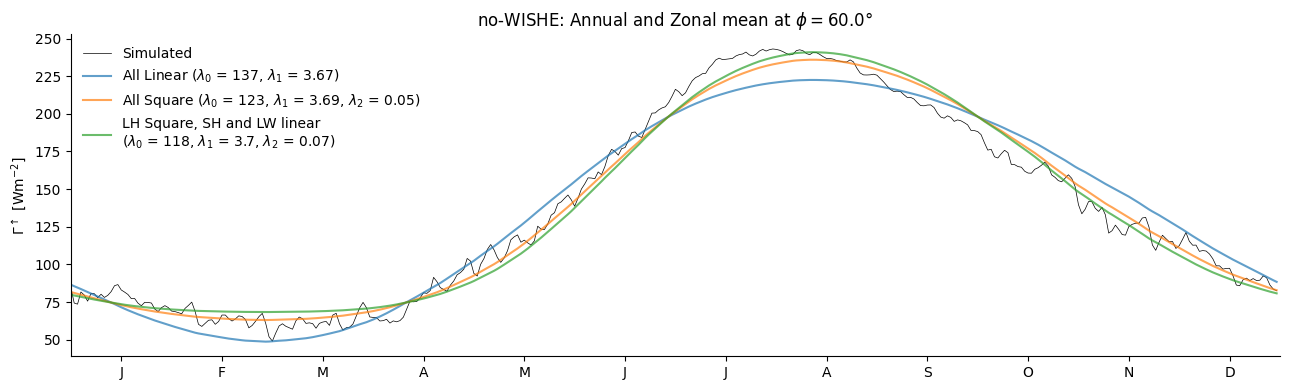

In [417]:
def linear_func(x_var, a, b):
    return a + b*x_var

def square_func(x_var, a, b, c):
    return a + b*x_var + c*x_var**2

t_surf_anom = np.asarray(ds_use.t_surf-ds_use.t_surf.mean())
gamma_up = np.asarray(ds_use.lwup_sfc - ds_use.lwdn_sfc + ds_use.flux_lhe + ds_use.flux_t)
fit_args_linear = optimize.curve_fit(linear_func, t_surf_anom, gamma_up, [80, 3])[0]
fit_args_square = optimize.curve_fit(square_func, t_surf_anom, gamma_up, [80, 3, 0])[0]
fit_flux = {'lh': {}, 'sh': {}, 'lw': {}}
for i, flux in enumerate([np.asarray(ds_use.flux_lhe), np.asarray(ds_use.flux_t), np.asarray(ds_use.lwup_sfc - ds_use.lwdn_sfc)]):
    fit_flux[list(fit_flux.keys())[i]]['linear'] = optimize.curve_fit(linear_func, t_surf_anom, flux, [80, 3])[0]
    fit_flux[list(fit_flux.keys())[i]]['square'] = optimize.curve_fit(square_func, t_surf_anom, flux, [80, 3, 0])[0]

fit_args_lh_square = fit_flux['lh']['square'] + np.pad(fit_flux['sh']['linear'], (0, 1), 'constant', constant_values=0) + \
                     np.pad(fit_flux['lw']['linear'], (0, 1), 'constant', constant_values=0)

fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.plot(time_array, gamma_up, color='k', lw=0.5, label='Simulated')
ax.plot(time_array, linear_func(np.asarray(ds_use.t_surf-ds_use.t_surf.mean()), *fit_args_linear), alpha=0.7, 
        label=f'All Linear ($\lambda_0$ = {round(fit_args_linear[0])}, $\lambda_1$ = {round(fit_args_linear[1], 2)})')
ax.plot(time_array, square_func(np.asarray(ds_use.t_surf-ds_use.t_surf.mean()), *fit_args_square), alpha=0.7, 
        label=f'All Square ($\lambda_0$ = {round(fit_args_square[0])}, $\lambda_1$ = {round(fit_args_square[1], 2)}, '
              f'$\lambda_2$ = {round(fit_args_square[2], 2)})')
ax.plot(time_array, square_func(np.asarray(ds_use.t_surf-ds_use.t_surf.mean()), *fit_args_lh_square), alpha=0.7, 
        label=f'LH Square, SH and LW linear\n($\lambda_0$ = {round(fit_args_lh_square[0])}, $\lambda_1$ = {round(fit_args_lh_square[1], 2)}, '
              f'$\lambda_2$ = {round(fit_args_lh_square[2], 2)})')
ax.legend(frameon=False)
ax.set_ylabel('$\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
ax.set_title(f"{exp_labels[exp_ind_use]}: Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$")
plt.tight_layout()

The similarity between the orange and green lines above suggest that the $T^2$ correction is only required for the latent heat flux term. This is confirmed below, by the fit to the individual fluxes.

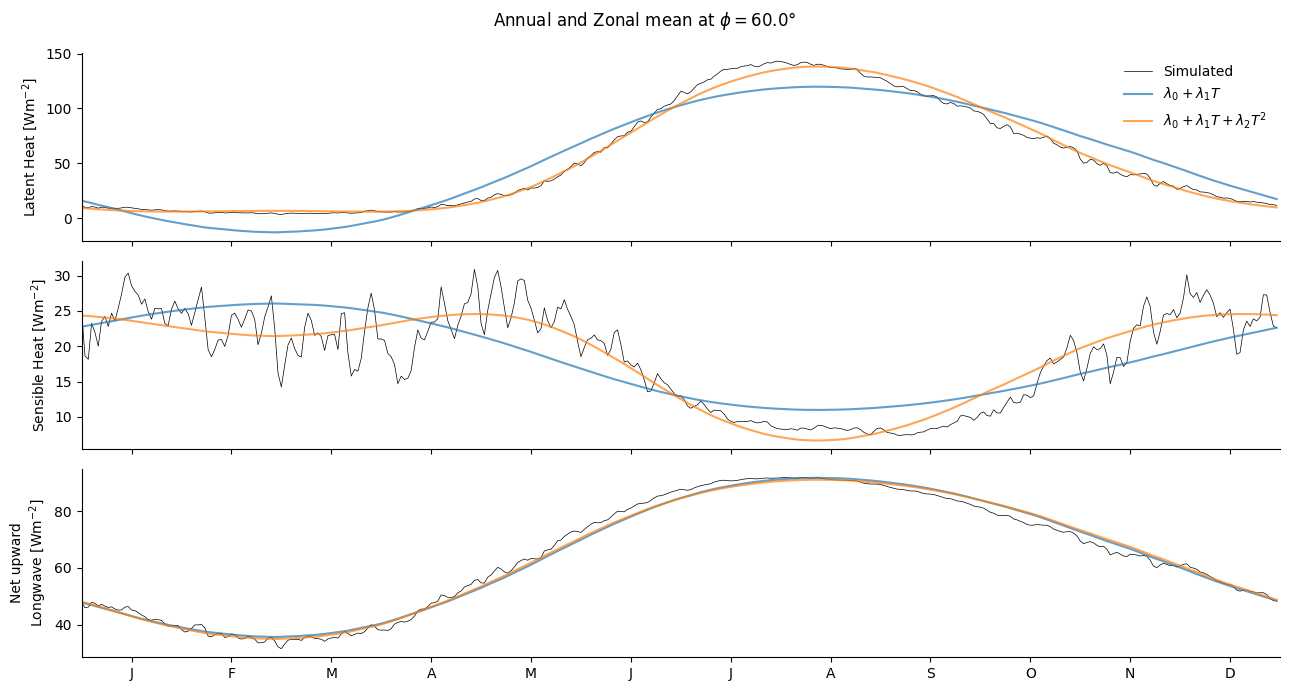

In [418]:
fig, ax = plt.subplots(3,1, figsize=(13, 7), sharex=True)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(0, n_year_days)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)

ax[0].plot(time_array, ds_use.flux_lhe, color='k', lw=0.5, label='Simulated')
ax[0].plot(time_array, linear_func(t_surf_anom, *fit_flux['lh']['linear']), label='$\lambda_0 + \lambda_1 T$', alpha=0.7)
ax[0].plot(time_array, square_func(t_surf_anom, *fit_flux['lh']['square']), label='$\lambda_0 + \lambda_1 T + \lambda_2 T^2$', alpha=0.7)

ax[1].plot(time_array, ds_use.flux_t, color='k', lw=0.5)
ax[1].plot(time_array, linear_func(t_surf_anom, *fit_flux['sh']['linear']), label='$\lambda_0 + \lambda_1 T$', alpha=0.7)
ax[1].plot(time_array, square_func(t_surf_anom, *fit_flux['sh']['square']), label='$\lambda_0 + \lambda_1 T + \lambda_2 T^2$', alpha=0.7)

ax[2].plot(time_array, ds_use.lwup_sfc - ds_use.lwdn_sfc, color='k', lw=0.5)
ax[2].plot(time_array, linear_func(t_surf_anom, *fit_flux['lw']['linear']), label='$\lambda_0 + \lambda_1 T$', alpha=0.7)
ax[2].plot(time_array, square_func(t_surf_anom, *fit_flux['lw']['square']), label='$\lambda_0 + \lambda_1 T + \lambda_2 T^2$', alpha=0.7)


ax[0].legend(frameon=False)
ax[0].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[1].set_ylabel('Sensible Heat [Wm$^{-2}$]')
ax[2].set_ylabel('Net upward\nLongwave [Wm$^{-2}$]')
fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$')
plt.tight_layout();

## Solving Equation with $T^2$ term
The equation including the $T^2$ is: 

$C\frac{\partial T}{\partial t} \approx F_s(t) - \lambda_0 - \lambda_1 T - \lambda_2 T^2$ where $F_s(t) \approx F_0 + F_1\cos(2\pi ft) + \frac{F_2}{F_1}F_1\cos(4\pi ft)$

Let us seek a fourier series solution for $T(t)$ with two harmonics, so it is the same form as $F_s(t)$:
$$T(t) \approx T_0 + T_1\cos(2\pi ft - \phi_1) + T_2\cos(4\pi ft - \phi_2)$$

This is the exact solution to the equation if $\lambda_2=0$ but is not exact if $\lambda_2 \neq 0$ as shown below.

The black dotted line shows $F_s(t)$ approximated using the fourier series with two harmonics.

The coloured lines show $C\frac{\partial T}{\partial t} + \lambda_0 + \lambda_1 T + \lambda_2 T^2$ with the $\lambda_2$ value indicated, and with $T(t)$ found using least squares regression given the above form as a fourier series solution with two harmonics.

For $\lambda_2=0$, the coloured line exactly matches the black line, indicating that the form of $T$ used is the exact solution. For larger values of $\lambda_2$, the coloured line differs from the black dotted line, indicating that the assumed form of $T(t)$ is wrong.

If the number of harmonics for temperature is increased to 3, the $T(t)$ solution becomes approximately exact for a larger range of $\lambda_2$.

In [419]:
# def fourier_series(time, coefs_amp, coefs_phase):
#     n_harmonics = len(coefs_amp)
#     ans = 0.5 * coefs_amp[0]
#     for n in range(1, n_harmonics):
#         ans += coefs_amp[n] * np.cos(2*n*np.pi*time/n_year_days - coefs_phase[n-1])
#     return ans
# 
# def fourier_series_deriv(time, coefs_amp, coefs_phase):
#     n_harmonics = len(coefs_amp)
#     ans = 0
#     for n in range(1, n_harmonics):
#         ans -= coefs_amp[n] * np.sin(2*n*np.pi*time/n_year_days - coefs_phase[n-1]) * (2*n*np.pi/n_year_days)
#     return ans / (24*60**2)     # convert units from per day to per second
# 
# def get_fourier_coef(var, time, n, T=n_year_days, integ_method='spline'):
#     # Computes the analytical fourier coefficients for the n harmonic of a given function
#     # With integrate method = spline works very well i.e. fit spline then use spline.integrate functionality
#     # Otherwise, there are problems with the integration especially at the limits e.g. t=0 and t=T.
#     if integ_method == 'spline':
#         var = np.append(var, var[0])
#         time = np.append(time, time[-1]+1)
#     if n == 0:
#         if integ_method == 'spline':
#             spline = CubicSpline(time,var, bc_type='periodic')
#             return 2/T * spline.integrate(0, T)
#         else:
#             return 2/T * integrate.simpson(var, time)
#     else:
#         # constants for acos(t) + bsin(t) form
#         if integ_method == 'spline':
#             spline = CubicSpline(time,var * np.cos(2*n*np.pi*time/T), bc_type='periodic')
#             cos_coef = 2/T * spline.integrate(0, T)
#             sin_curve = var * np.sin(2*n*np.pi*time/T)
#             sin_curve[-1] = 0       # Need first and last value to be the same to be periodic spline
#                                     # usually have last value equal 1e-10 so not equal
#             spline = CubicSpline(time,sin_curve, bc_type='periodic')
#             sin_coef = 2/T * spline.integrate(0, T)
#         else:
#             cos_coef = 2/T * integrate.simpson(var * np.cos(2*n*np.pi*time/T), time)
#             sin_coef = 2/T * integrate.simpson(var * np.sin(2*n*np.pi*time/T), time)
#         # constants for Acos(t-phi) form 
#         phase_coef = np.arctan(sin_coef/cos_coef)
#         amp_coef = cos_coef / np.cos(phase_coef)
#         return amp_coef, phase_coef
# 
# def get_fourier_fit(time, var, n_harmonics, T=n_year_days, integ_method='spline'):
#     # Returns the fourier fit of a function using a given number of harmonics
#     amp_coefs = np.zeros(n_harmonics+1)
#     phase_coefs = np.zeros(n_harmonics)
#     amp_coefs[0] = get_fourier_coef(var, time, 0, T, integ_method)
#     for i in range(1, n_harmonics+1):
#         amp_coefs[i], phase_coefs[i-1] = get_fourier_coef(var, time, i, T, integ_method)
#     return fourier_series(time, amp_coefs, phase_coefs), amp_coefs, phase_coefs

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


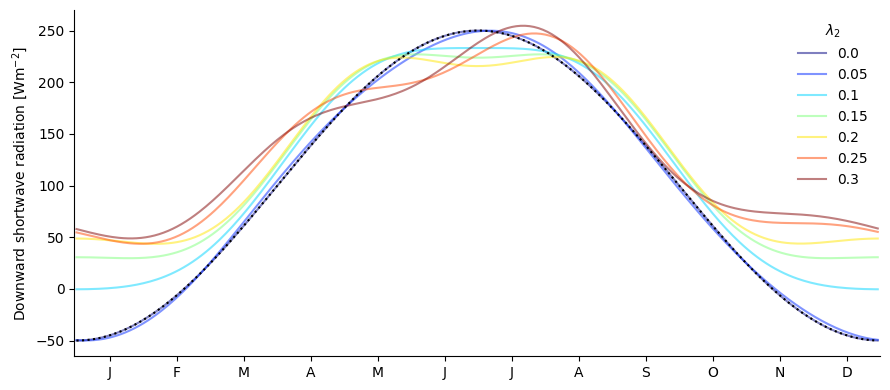

In [420]:
def get_sw_fourier_approx(time, sw_fourier_amp, sw_fourier_phase, lambda_const, heat_capacity, n_harmonics=2):
    sw_fourier = fourier.fourier_series(time, n_year_days, sw_fourier_amp, sw_fourier_phase)
    
    def surface_energy_lhs(time, *args):
        amp_args = [args[i] for i in range(n_harmonics+1)]
        phase_args = [args[i] for i in range(n_harmonics+1,len(args))]
        temp_fourier = fourier.fourier_series(time, n_year_days, amp_args, phase_args)
        return heat_capacity * fourier.fourier_series_deriv(time, n_year_days, amp_args, phase_args) + lambda_const[0] + \
            lambda_const[1] * temp_fourier + lambda_const[2] * temp_fourier**2
    
    args_found = optimize.curve_fit(surface_energy_lhs, time, sw_fourier, np.ones(2*n_harmonics+1))[0]
    return surface_energy_lhs(time, *args_found), args_found

heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[exp_ind_use])
n_temp_harmonics = 2
sw_amp0 = 200
sw_amp1 = -150
sw_phase = [0, 0]
lambda_0 = 100
lambda_1 = 3
lambda_2 = 0.03
lambda_2_array = np.linspace(0, 0.3, 7)

fig, ax = plt.subplots(1,1, figsize=(9, 4))
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
ax.spines[['top', 'right']].set_visible(False)
color_seq = plt.cm.jet(np.linspace(0,1,len(lambda_2_array)))
for i in range(len(lambda_2_array)):
    sw_plot = get_sw_fourier_approx(time_array, [sw_amp0, sw_amp1, 0], sw_phase, 
                                    [lambda_0, lambda_1, lambda_2_array[i]], heat_capacity, n_temp_harmonics)[0]
    ax.plot(time_array, sw_plot, color=color_seq[i], alpha=0.5, label=round(lambda_2_array[i], 2))
ax.plot(time_array, fourier.fourier_series(time_array, n_year_days, [sw_amp0, sw_amp1, 0], sw_phase), color='k', linestyle=':', label='')
ax.set_ylabel('Downward shortwave radiation [Wm$^{-2}$]')
ax.legend(frameon=False, title='$\lambda_2$')
plt.tight_layout()

### Effect of $\lambda_2$ on the seasonal cycle of temperature
Below, I investigate the effect of the $\lambda_2$ parameter on the seasonal cycle of temperature. I only consider $\lambda_2<0.05$, as from the above plot, the assumed two harmonic fourier solution for $T(t)$ is still pretty good for $\lambda_2$ in this range, and the $\lambda_2$ values I encounter also tend to be in this range.

It seems that increasing $\lambda_2$ pushes the coldest day of the year later, while leaving the date of the hottest day of the year unchanged. It also seems to increase the amplitude of the seasonal cycle.

This is different to $\lambda_1$, which pulls both the hottest and coldest day earlier by the same amount.

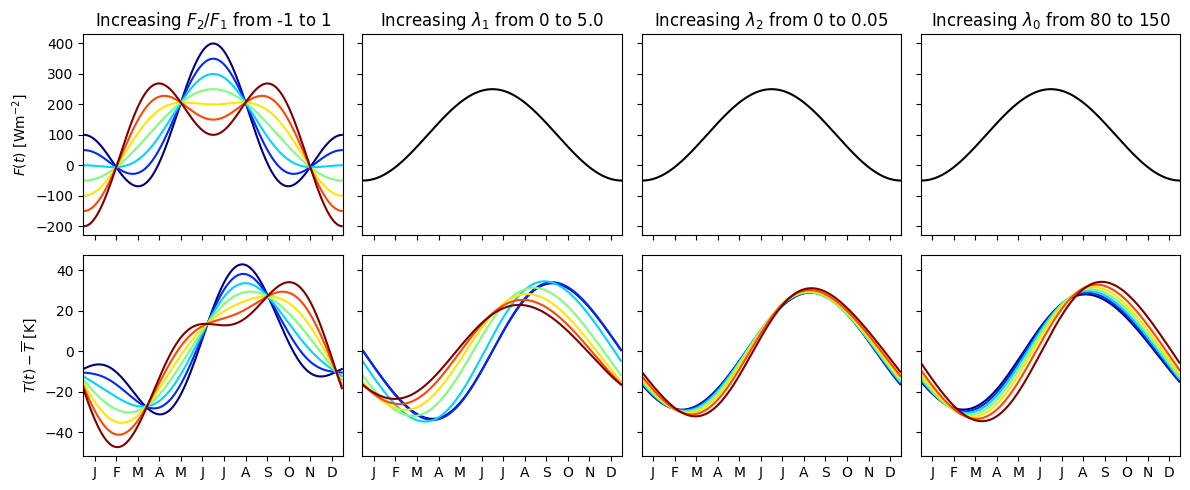

In [421]:
def get_temp_fourier_coefs(time, sw_fourier_amp, sw_fourier_phase, lambda_const, heat_capacity, n_harmonics=2):
    sw_fourier = fourier.fourier_series(time, n_year_days, sw_fourier_amp, sw_fourier_phase)
    
    def surface_energy_lhs(time, *args):
        amp_args = [args[i] for i in range(n_harmonics+1)]
        phase_args = [args[i] for i in range(n_harmonics+1,len(args))]
        temp_fourier = fourier.fourier_series(time, n_year_days, amp_args, phase_args)
        return heat_capacity * fourier.fourier_series_deriv(time, n_year_days, amp_args, phase_args) + lambda_const[0] + \
            lambda_const[1] * temp_fourier + lambda_const[2] * temp_fourier**2
    
    args_found = optimize.curve_fit(surface_energy_lhs, time, sw_fourier, np.ones(2*n_harmonics+1))[0]
    return args_found[:n_harmonics+1], args_found[n_harmonics+1:]

n_temp_harmonics = 2
sw_amp0 = 200
sw_amp1 = -150
sw_phase = [0, 0]
lambda_0 = 100
lambda_1 = 3
lambda_2 = 0.03
sw_ratio = np.linspace(-1, 1, 7)
lambda_1_array = np.linspace(0, 5, 7)
lambda_2_array = np.linspace(0, 0.05, 7)
lambda_0_array = np.linspace(80, 150, 7)

fig, ax = plt.subplots(2,4, figsize=(12, 5), sharex=True, sharey='row')
color_seq = plt.cm.jet(np.linspace(0,1,len(sw_ratio)))
for i in range(len(sw_ratio)):
    ax[0, 0].plot(time_array, fourier.fourier_series(time_array, n_year_days, [sw_amp0, sw_amp1, sw_amp1 * sw_ratio[i]], sw_phase), color=color_seq[i])
    temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(time_array, [sw_amp0, sw_amp1, sw_amp1 * sw_ratio[i]], sw_phase, 
                                                              [lambda_0, lambda_1, lambda_2], heat_capacity, n_harmonics=n_temp_harmonics)
    temp_plot = fourier.fourier_series(time_array, n_year_days, temp_amp_coefs, temp_phase_coefs)
    ax[1, 0].plot(time_array, temp_plot-np.mean(temp_plot), color=color_seq[i])

ax[0, 1].plot(time_array, fourier.fourier_series(time_array, n_year_days, [sw_amp0, sw_amp1, 0], np.zeros(2)), color='k')
for i in range(len(lambda_1_array)):
    temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(time_array, [sw_amp0, sw_amp1, 0], sw_phase, 
                                                              [lambda_0, lambda_1_array[i], lambda_2], heat_capacity, n_harmonics=n_temp_harmonics)
    temp_plot = fourier.fourier_series(time_array, n_year_days, temp_amp_coefs, temp_phase_coefs)
    ax[1, 1].plot(time_array, temp_plot-np.mean(temp_plot), color=color_seq[i])
    
ax[0, 2].plot(time_array, fourier.fourier_series(time_array, n_year_days, [sw_amp0, sw_amp1, 0], np.zeros(2)), color='k')
for i in range(len(lambda_2_array)):
    temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(time_array, [sw_amp0, sw_amp1, 0], sw_phase, 
                                                              [lambda_0, lambda_1, lambda_2_array[i]], heat_capacity, n_harmonics=n_temp_harmonics)
    temp_plot = fourier.fourier_series(time_array, n_year_days, temp_amp_coefs, temp_phase_coefs)
    ax[1, 2].plot(time_array, temp_plot-np.mean(temp_plot), color=color_seq[i])
    
ax[0, 3].plot(time_array, fourier.fourier_series(time_array, n_year_days, [sw_amp0, sw_amp1, 0], np.zeros(2)), color='k')
for i in range(len(lambda_0_array)):
    temp_amp_coefs, temp_phase_coefs = get_temp_fourier_coefs(time_array, [sw_amp0, sw_amp1, 0], sw_phase, 
                                                              [lambda_0_array[i], lambda_1, lambda_2], heat_capacity, n_harmonics=n_temp_harmonics)
    temp_plot = fourier.fourier_series(time_array, n_year_days, temp_amp_coefs, temp_phase_coefs)
    ax[1, 3].plot(time_array, temp_plot-np.mean(temp_plot), color=color_seq[i])

ax[0, 0].set_xlim(-1,360)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_title('Increasing $F_2/F_1$ from -1 to 1')
ax[0, 1].set_title(f'Increasing $\lambda_1$ from 0 to {lambda_1_array[-1]}')
ax[0, 0].set_ylabel('$F(t)$ [Wm$^{-2}$]')
ax[1, 0].set_ylabel('$T(t) - \overline{T}$ [K]')
ax[0, 2].set_title(f'Increasing $\lambda_2$ from 0 to {lambda_2_array[-1]}')
ax[0, 3].set_title(f'Increasing $\lambda_0$ from {int(lambda_0_array[0])} to {int(lambda_0_array[-1])}')
plt.tight_layout()

In [422]:
# Compare 3 harmonic vs 2 harmonic fit
# temp_plot3 = temp_plot
# fig, ax = plt.subplots(1,1, figsize=(9, 5), sharex=True, sharey='row')
# ax.set_xticks(*month_ticks)
# ax.plot(temp_plot3-temp_plot2)
# ax.set_xlim(-1, n_year_days)
# ax.set_ylabel('3 Harmonics - 2 Harmonics Temnperature [K]')
# ax.set_title('$\lambda_2 = 0.05$')
# ax.hlines(0, -1, n_year_days, lw=0.1, color='k')
# plt.tight_layout()

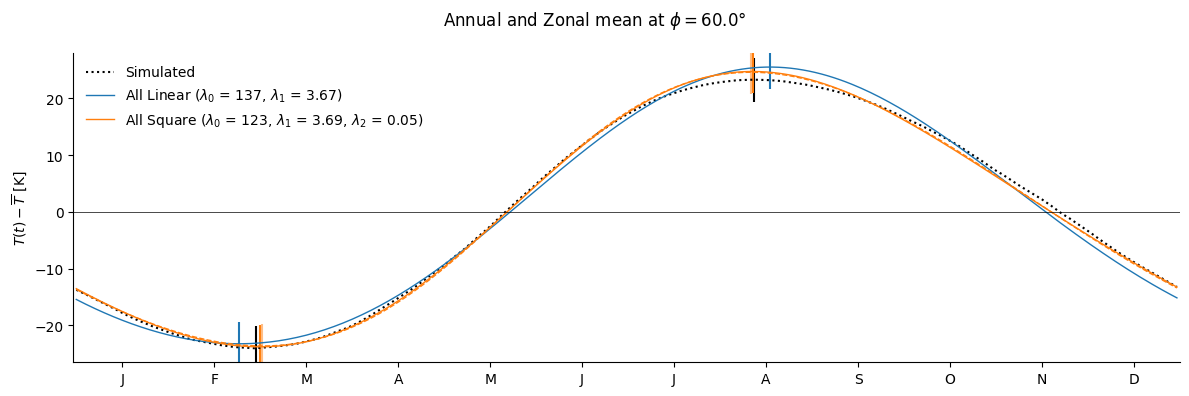

In [423]:
sw_sl_amp_coefs = fourier.get_fourier_fit(time_array, ds_use.swdn_sfc, n_year_days, 2)[1]
sw_sl_phase_coefs = np.zeros(2)
temp_sl_amp_coefs = {}
temp_sl_phase_coefs = {}
temp_sl_amp_coefs['linear'], temp_sl_phase_coefs['linear'] = get_temp_fourier_coefs(time_array, sw_sl_amp_coefs, sw_sl_phase_coefs, 
                                                                [fit_args_linear[0], fit_args_linear[1], 0], heat_capacity, n_harmonics=2)
temp_sl_amp_coefs['square'], temp_sl_phase_coefs['square'] = get_temp_fourier_coefs(time_array, sw_sl_amp_coefs, sw_sl_phase_coefs, 
                                                                [fit_args_square[0], fit_args_square[1], fit_args_square[2]], 
                                                                                          heat_capacity, n_harmonics=2)
temp_sl_amp_coefs['square3'], temp_sl_phase_coefs['square3'] = get_temp_fourier_coefs(time_array, sw_sl_amp_coefs, sw_sl_phase_coefs, 
                                                                [fit_args_square[0], fit_args_square[1], fit_args_square[2]], 
                                                                                          heat_capacity, n_harmonics=3)
temp_sl_amp_coefs['lh_square'], temp_sl_phase_coefs['lh_square'] = get_temp_fourier_coefs(time_array, sw_sl_amp_coefs, sw_sl_phase_coefs, 
                                                                [fit_args_lh_square[0], fit_args_lh_square[1], fit_args_lh_square[2]], 
                                                                                          heat_capacity, n_harmonics=2)
temp_sl_amp_coefs['lh_square3'], temp_sl_phase_coefs['lh_square3'] = get_temp_fourier_coefs(time_array, sw_sl_amp_coefs, sw_sl_phase_coefs, 
                                                                [fit_args_lh_square[0], fit_args_lh_square[1], fit_args_lh_square[2]], 
                                                                                          heat_capacity, n_harmonics=3)
temp_sl_fourier_fit = {}
for key in temp_sl_amp_coefs:
    temp_sl_fourier_fit[key] = fourier.fourier_series(time_array, n_year_days, temp_sl_amp_coefs[key], temp_sl_phase_coefs[key])

# Obtain the extrema values obtained by the different fits
spline_spacing_temp = 20
extrema_sl_date = {'max': {}, 'min': {}}
extrema_sl_value = {'max': {}, 'min': {}}
for var_name in ['simulated'] + list(temp_sl_fourier_fit.keys()):
    if var_name == 'simulated':
        var = ds_use.t_surf
    else:
        var = temp_sl_fourier_fit[var_name]
    for key in ['max', 'min']:
        extrema_sl_date[key][var_name], extrema_spline = get_var_extrema_date(time_array, var, spline_spacing_temp, key, float(var.mean()))
        extrema_sl_value[key][var_name] = extrema_spline(extrema_sl_date[key][var_name]) - float(var.mean())

fig, ax = plt.subplots(1,1, figsize=(12, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(time_array, ds_use.t_surf-ds_use.t_surf.mean(), color='k', linestyle=':', label='Simulated')
ax.plot(time_array, temp_sl_fourier_fit['linear']-temp_sl_fourier_fit['linear'].mean(), color=default_colors[0], lw=1, 
        label=f'All Linear ($\lambda_0$ = {round(fit_args_linear[0])}, $\lambda_1$ = {round(fit_args_linear[1], 2)})')
ax.plot(time_array, temp_sl_fourier_fit['square']-temp_sl_fourier_fit['square'].mean(), color=default_colors[1], lw=1, 
        label=f'All Square ($\lambda_0$ = {round(fit_args_square[0])}, $\lambda_1$ = {round(fit_args_square[1], 2)}, '
              f'$\lambda_2$ = {round(fit_args_square[2], 2)})')
ax.plot(time_array, temp_sl_fourier_fit['square3']-temp_sl_fourier_fit['square3'].mean(), color=default_colors[1], linestyle='--', lw=1)

for key in extrema_sl_date:
    for var_name in extrema_sl_date['max']:
        if 'lh' in var_name:
            continue
        if var_name == 'simulated':
            colour_use = 'k'
        elif 'linear' in var_name:
            colour_use = default_colors[0]
        else:
            colour_use = default_colors[1]
        ax.scatter(extrema_sl_date[key][var_name], extrema_sl_value[key][var_name], 
                        color=colour_use, alpha=0.5 if '3' in var_name else 1, marker='|', s=1000)

ax.hlines(0, -1, n_year_days, color='k', lw=0.5)
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
ax.set_ylabel('$T(t) - \overline{T}$ [K]')
ax.legend(frameon=False)
fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$')
plt.tight_layout()

In [424]:
ds_global = annual_mean(ds_base[exp_ind_use].mean(dim='lon')).load()
n_lat = len(ds_global.lat)

In [425]:
# Get empirical lambda coefficients at each latitude
lambda_global = {'linear': np.zeros((n_lat, 3)), 'square': np.zeros((n_lat, 3))}
gamma_up_global = ds_global.flux_lhe + ds_global.flux_t + ds_global.lwup_sfc - ds_global.lwdn_sfc
t_surf_anom_global = ds_global.t_surf-ds_global.t_surf.mean(dim='time')
for i in range(n_lat):
    lambda_global['linear'][i, :2] = optimize.curve_fit(linear_func, np.asarray(t_surf_anom_global.isel(lat=i)), 
                                                        np.asarray(gamma_up_global.isel(lat=i)), [80, 3])[0]
    lambda_global['square'][i] = optimize.curve_fit(square_func, np.asarray(t_surf_anom_global.isel(lat=i)), 
                                                    np.asarray(gamma_up_global.isel(lat=i)), [80, 3, 0])[0]
lambda_global['square_no_lambda2'] = 1 * lambda_global['square']
lambda_global['square_no_lambda2'][:, 2] = 0

In [426]:
# Get insolation fourier coefficients at each latitude
n_sw_harmonics = 2
sw_amp_coefs_global = np.zeros((n_lat, n_sw_harmonics+1))
sw_phase_coefs_global = np.zeros((n_lat, n_sw_harmonics))
for i in range(n_lat):
    sw_amp_coefs_global[i] = fourier.get_fourier_fit(time_array, ds_global.swdn_sfc.isel(lat=i), n_year_days, 2)[1]

In [427]:
temp_amp_coefs_global = {'linear': np.zeros((n_lat, 3)), 'square_no_lambda2': np.zeros((n_lat, 3)), 
                         'square': np.zeros((n_lat, 3)), 'square3': np.zeros((n_lat, 4))}
temp_phase_coefs_global = {'linear': np.zeros((n_lat, 2)), 'square_no_lambda2': np.zeros((n_lat, 2)), 
                           'square': np.zeros((n_lat, 2)), 'square3': np.zeros((n_lat, 3))}
extrema_date_global = {'max': {key: np.zeros((n_lat, 2)) for key in temp_amp_coefs_global}, 
                       'min': {key: np.zeros((n_lat, 2)) for key in temp_amp_coefs_global}}
for type in ['max', 'min']:
    extrema_date_global[type]['simulated'] = np.zeros((n_lat, 2))
    
for i in range(n_lat):
    for key in lambda_global:
        temp_amp_coefs_global[key][i], temp_phase_coefs_global[key][i] = get_temp_fourier_coefs(time_array, sw_amp_coefs_global[i],
                                                                                                      sw_phase_coefs_global[i], 
                                                                lambda_global[key][i], heat_capacity, n_harmonics=2)
        temp_amp_coefs_global['square3'][i], temp_phase_coefs_global['square3'][i] = get_temp_fourier_coefs(time_array, sw_amp_coefs_global[i],
                                                                                                      sw_phase_coefs_global[i], 
                                                                lambda_global['square'][i], heat_capacity, n_harmonics=3)  
    for key in temp_amp_coefs_global:
        temp_fourier_fit_global = fourier.fourier_series(time_array, n_year_days, temp_amp_coefs_global[key][i], temp_phase_coefs_global[key][i])
        for type in ['max', 'min']:
            extrema_date_global[type][key][i, :] = get_var_extrema_date(time_array, temp_fourier_fit_global, spline_spacing_temp, type, 
                                                                        float(temp_fourier_fit_global.mean()))[0]
    for type in ['max', 'min']:
        extrema_date_global[type]['simulated'][i, :] = get_var_extrema_date(time_array, ds_global.t_surf.isel(lat=i), spline_spacing_temp, type, 
                                                                            float(ds_global.t_surf.isel(lat=i).mean()))[0]
for type in ['max', 'min']:
    for key in extrema_date_global['max']:
        extrema_date_global[type][key] = np.sort(extrema_date_global[type][key], axis=1)

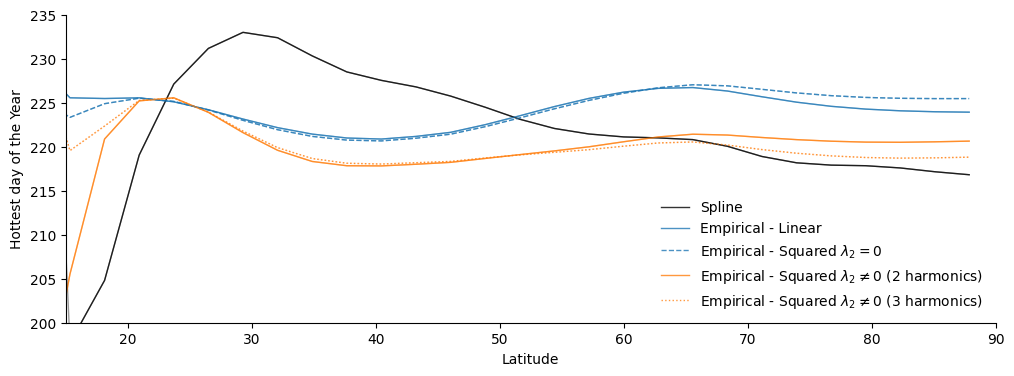

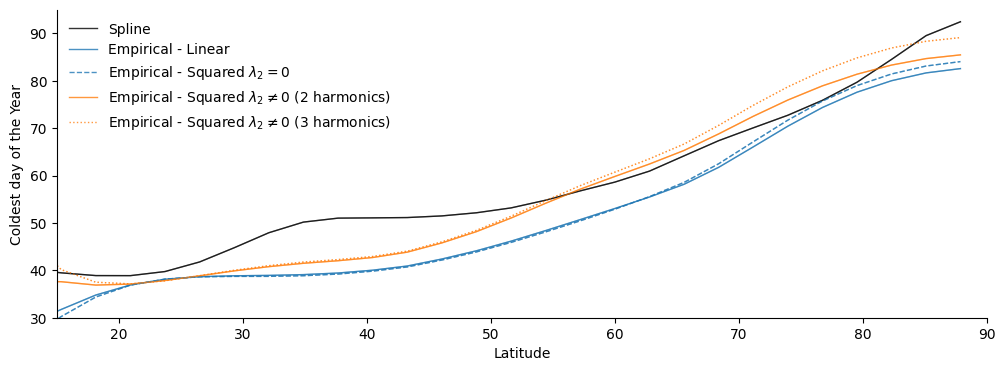

In [428]:
for type in extrema_date_global:
    fig, ax = plt.subplots(1,1, figsize=(12, 4))
    ax.spines[['top', 'right']].set_visible(False)
    for i in range(2):
        ax.plot(ds_global.lat, extrema_date_global[type]['simulated'][:, i], color='k', 
                label='Spline' if i==0 else None, lw=1, alpha=0.8 if i==0 else 0.4)
        ax.plot(ds_global.lat, extrema_date_global[type]['linear'][:, i], color=default_colors[0], 
                label='Empirical - Linear' if i==0 else None, lw=1, alpha=0.8 if i==0 else 0.4)
        ax.plot(ds_global.lat, extrema_date_global[type]['square_no_lambda2'][:, i], color=default_colors[0], linestyle='--',
                label='Empirical - Squared $\lambda_2=0$' if i==0 else None, lw=1, alpha=0.8 if i==0 else 0.4)
        ax.plot(ds_global.lat, extrema_date_global[type]['square'][:, i], color=default_colors[1], 
                label='Empirical - Squared $\lambda_2\\neq 0$ (2 harmonics)' if i==0 else None, lw=1, alpha=0.8 if i==0 else 0.4)
        ax.plot(ds_global.lat, extrema_date_global[type]['square3'][:, i], color=default_colors[1], linestyle=':', 
                label='Empirical - Squared $\lambda_2\\neq 0$ (3 harmonics)' if i==0 else None, lw=1, alpha=0.8 if i==0 else 0.4)
    ax.set_xlim(15, 90)
    ax.legend(frameon=False)
    ax.set_xlabel('Latitude')
    if type == 'max':
        ax.set_ylim(200, 235)
        ax.set_ylabel('Hottest day of the Year')
    else:
        ax.set_ylim(30, 95)
        ax.set_ylabel('Coldest day of the Year')